In [1]:
import os.path as osp
import sys
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path(osp.abspath("")).parents[0]
sys.path.append(str(root_path))

%config InlineBackend.figure_format='retina'

## Step 0: 设置环境

In [2]:
import numpy as np
from papers.Zhao2013.algorithm import SmoothedPath
from core.toolpath import LinearPath
import utils.visualization as vis
from core.look_ahead import BidirectionalScanner
from core.feedrate_scheduler import FeedrateScheduler
from core.interpolator import Interpolator

In [3]:
data_name = "butterfly"
file_path = f"./data/{data_name}.txt"
data_pts = np.loadtxt(file_path, delimiter="\t")
Ts = 0.0005

V_MAX = 10
A_MAX = 100
J_MAX = 10000
chord_error = 0.1
c1 = 0.5

print(f"Loaded data from {file_path}")
print(f"Data points shape: {data_pts.shape}")

Loaded data from ./data/butterfly.txt
Data points shape: (200, 2)


## Step 1: 生成线性路径和平滑路径

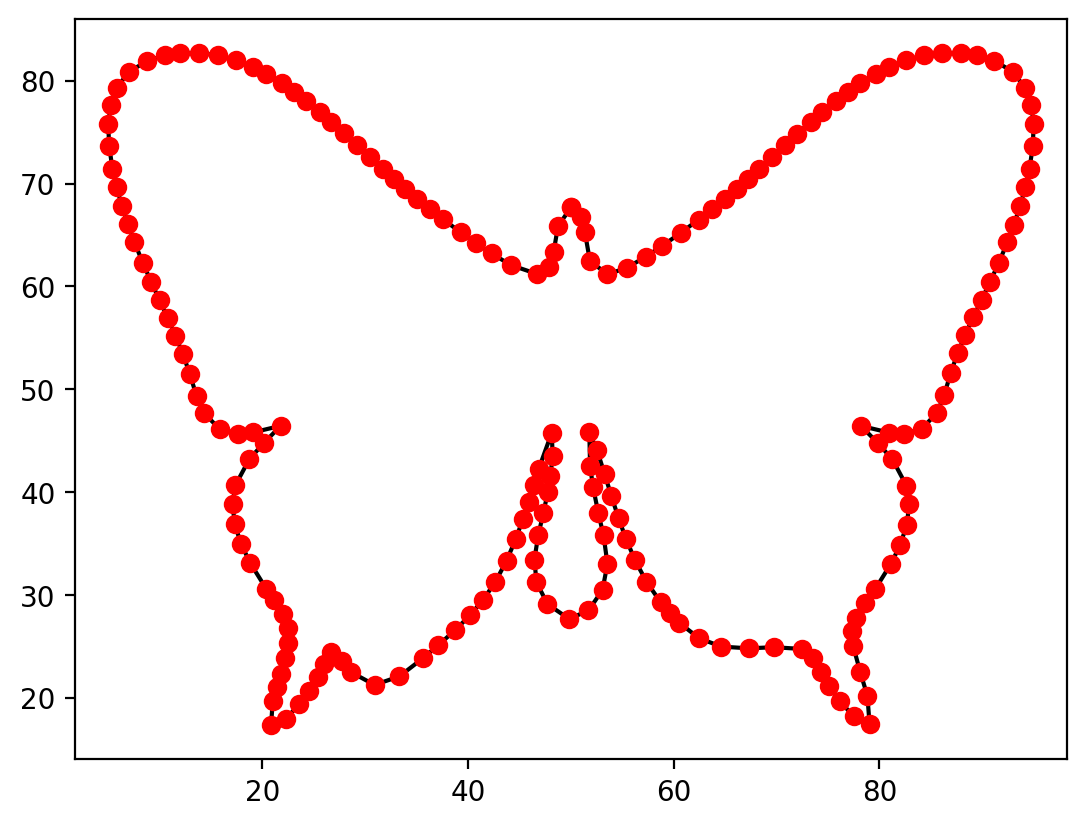

Total arc length: 390.03168235817697


In [4]:
linear_path = LinearPath(data_pts, chord_error)
vis.plot_path(linear_path)
linear_path_lengths = linear_path.lengths
print(f"Total arc length: {np.sum(linear_path_lengths)}")

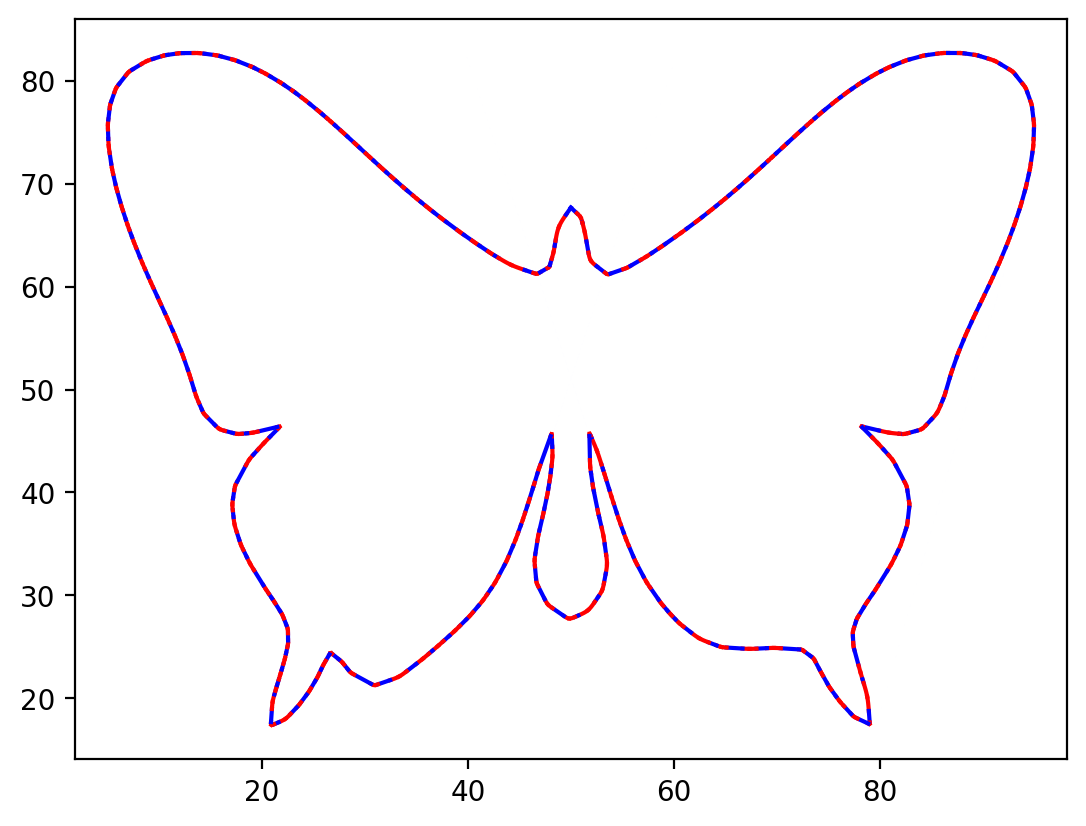

Total arc length: 388.4355097144207
Max curvature: 172.26986329730582


In [5]:
smooth_path = SmoothedPath(data_pts, chord_error, c1)
vis.plot_toolpath(smooth_path)
smooth_path_lengths = smooth_path.lengths
print(f"Total arc length: {np.sum(smooth_path_lengths)}")
print(f"Max curvature: {np.max(smooth_path.curvature_peaks)}")

## Step 2: 前瞻规划

通过双向扫描，计算每个连接点处的速度上界。

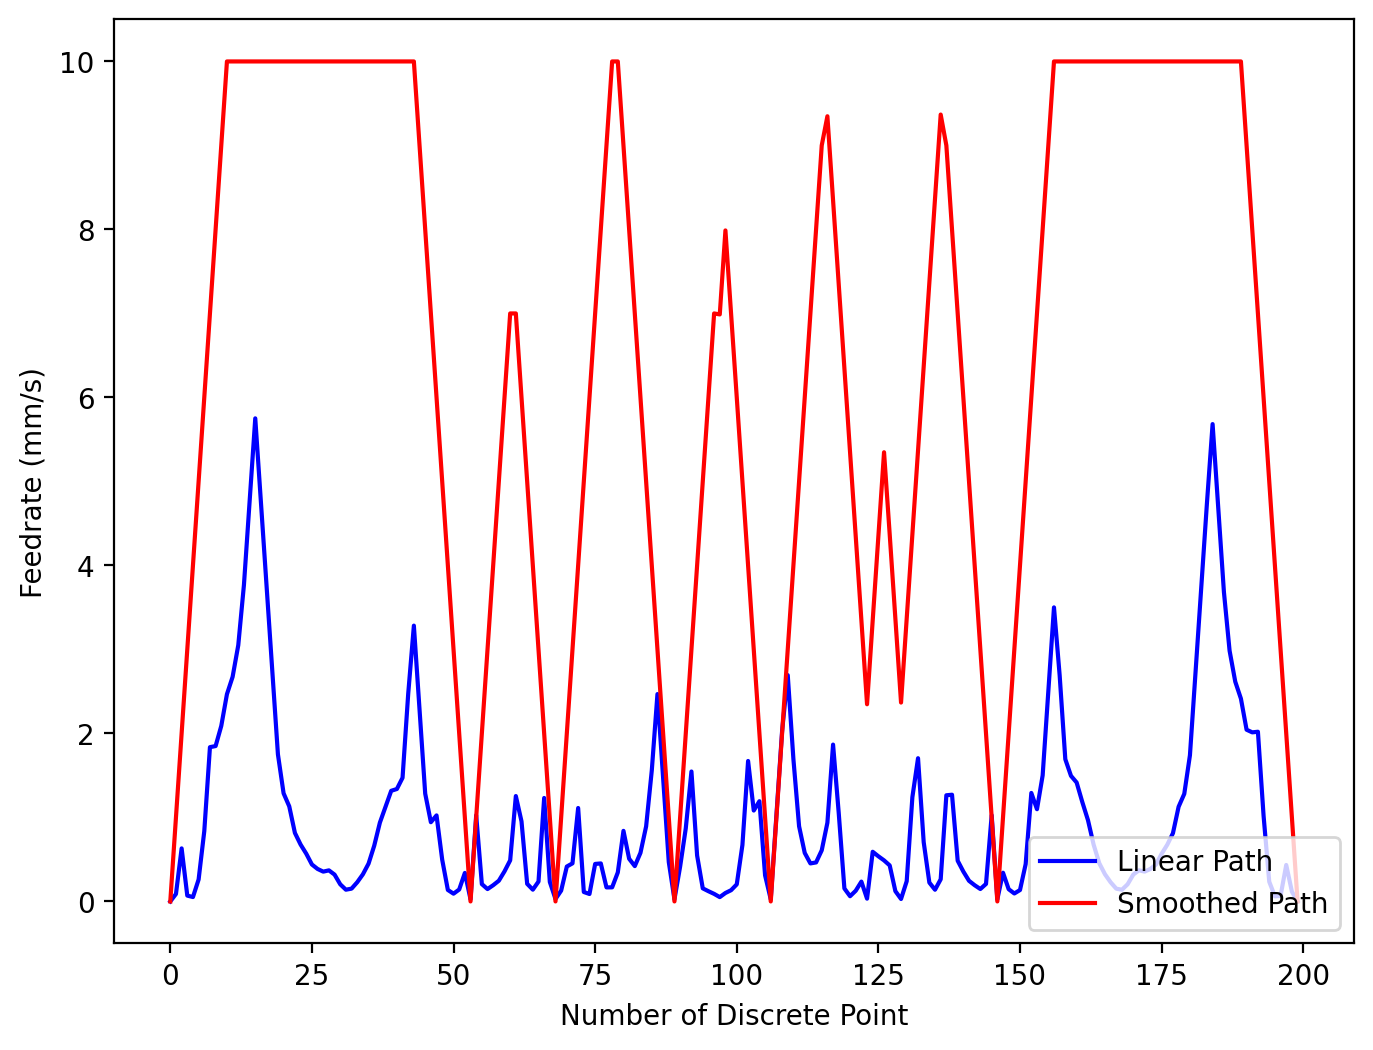

In [6]:
linear_scanner = BidirectionalScanner(linear_path, Ts, V_MAX, A_MAX, J_MAX)

scanner_smooth = BidirectionalScanner(smooth_path, Ts, V_MAX, A_MAX, J_MAX)

v_lim_linear = linear_scanner.v_limit
v_lim_smooth = scanner_smooth.v_limit

plt.figure(figsize=(8, 6))
plt.plot(v_lim_linear, "b-", label="Linear Path")
plt.plot(v_lim_smooth, "r-", label="Smoothed Path")
plt.xlabel("Number of Discrete Point")
plt.ylabel("Feedrate (mm/s)")
plt.legend(loc="lower right")
plt.show()

## Step 3: 进给率规划

连接点使用 Step 2 中的速度上界，中间的速度使用双S形曲线进行规划

Total time: 44.077246691975205


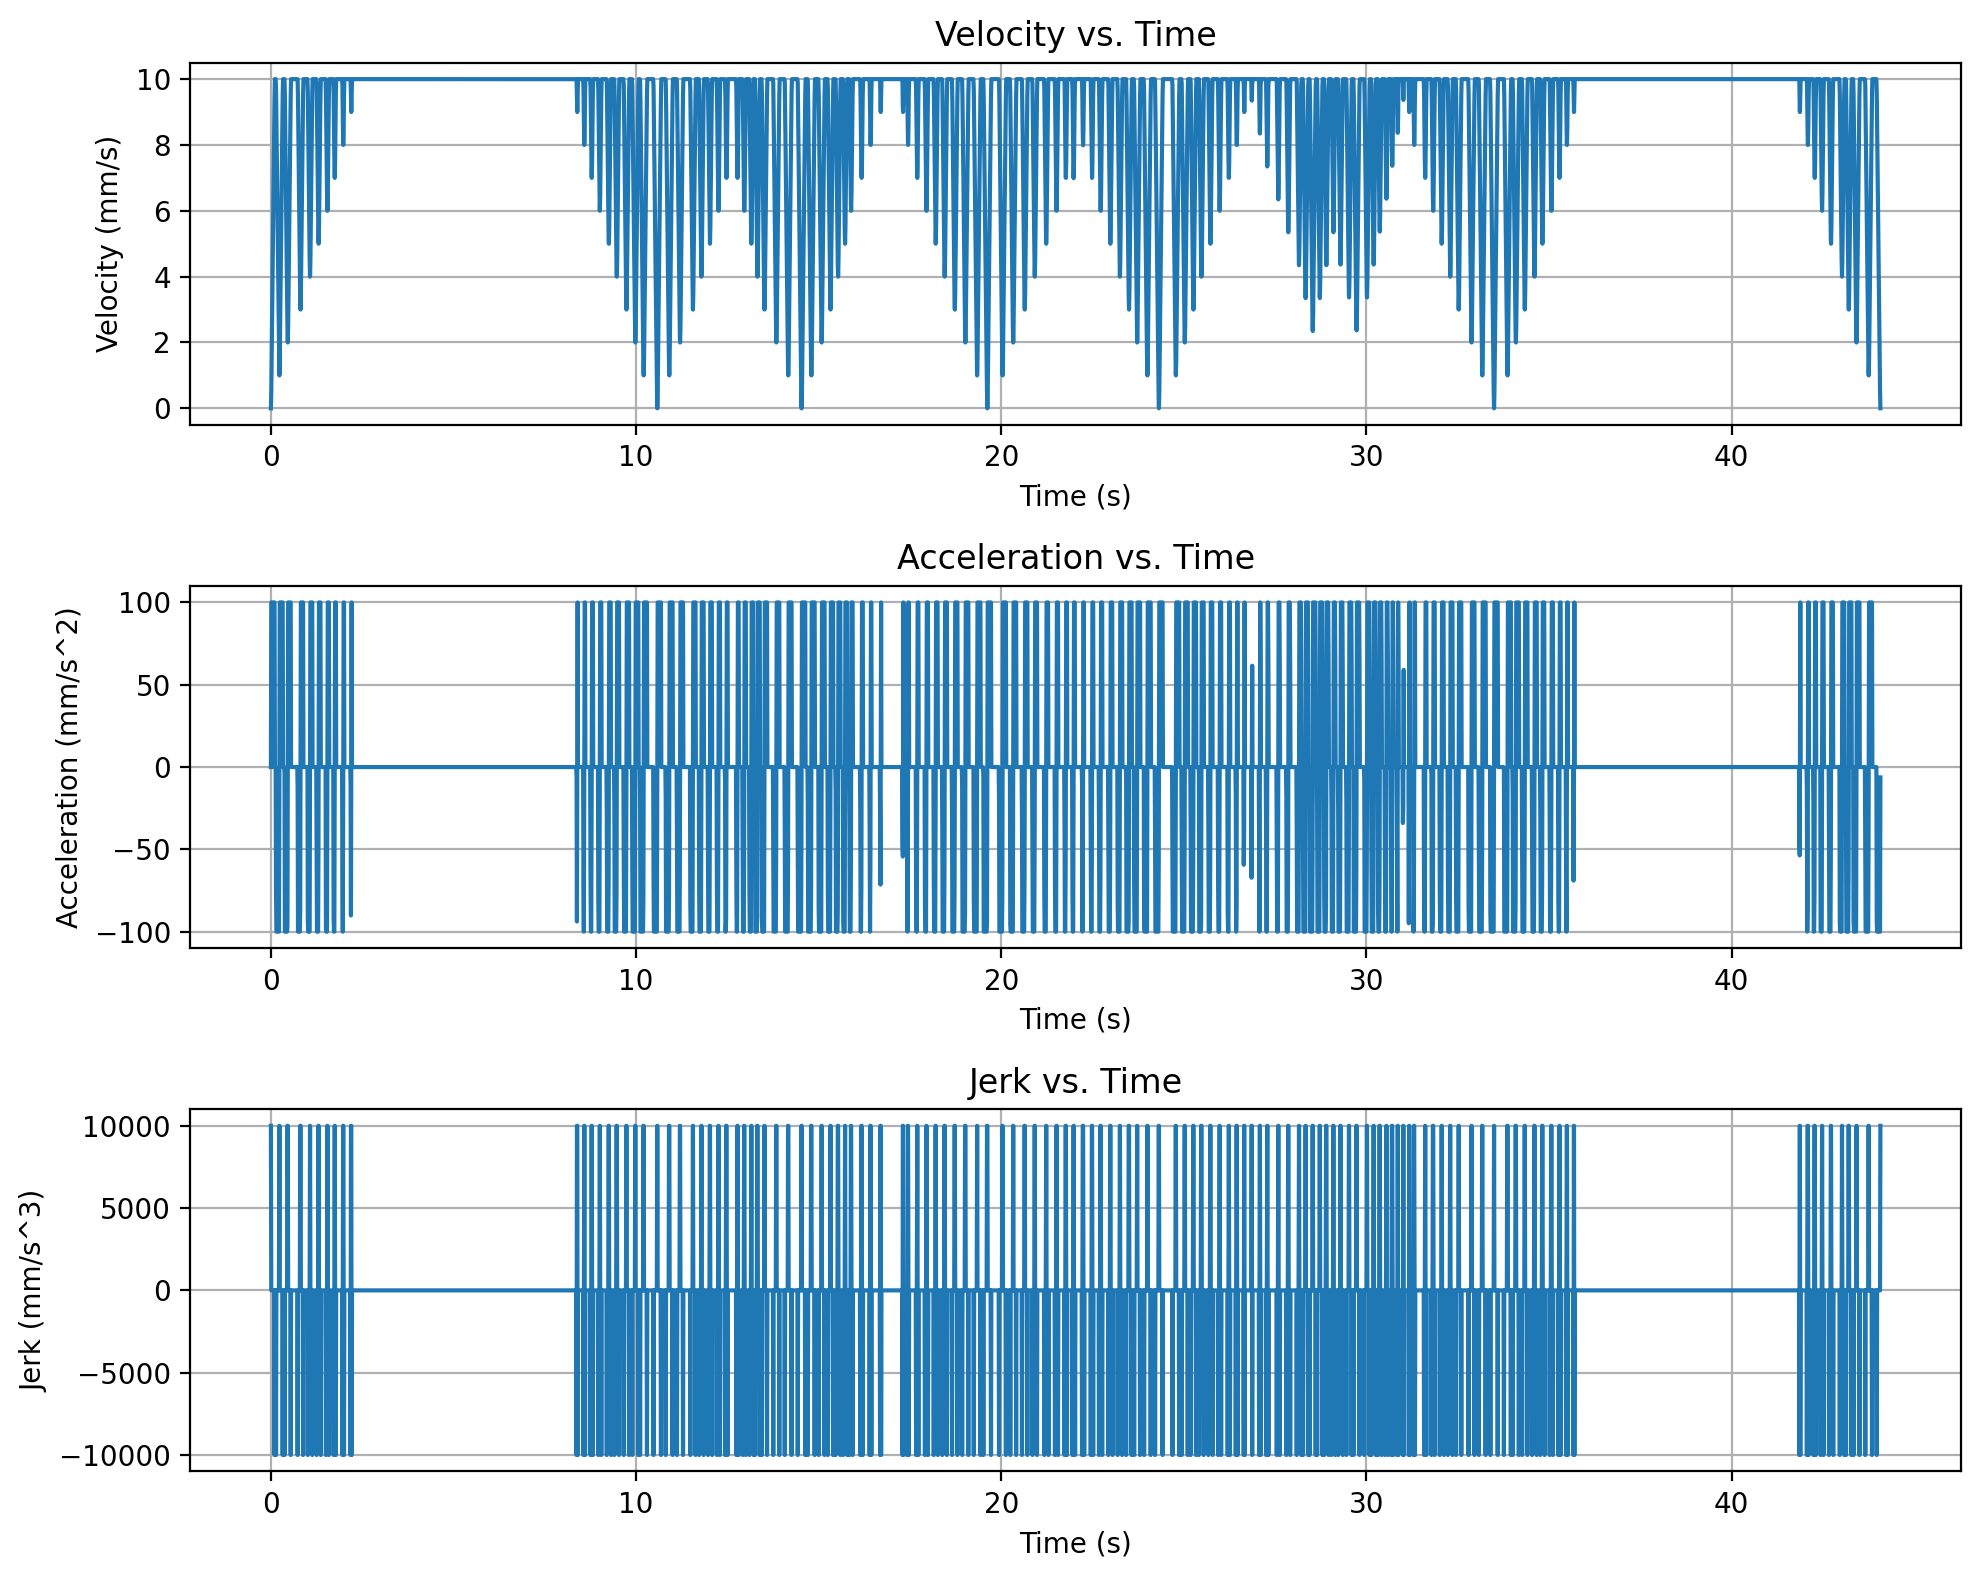

In [7]:
smooth_scheduler = FeedrateScheduler(smooth_path_lengths, v_lim_smooth, V_MAX, A_MAX, J_MAX, Ts)
smooth_profiles = smooth_scheduler.profiles
print(f"Total time: {smooth_scheduler.total_time}")

smooth_profile_data = smooth_scheduler.get_profile_data()
vis.plot_profiles(smooth_profile_data)

In [8]:
linear_scheduler = FeedrateScheduler(linear_path_lengths, v_lim_linear, V_MAX, A_MAX, J_MAX, Ts)
linear_profiles = linear_scheduler.profiles
print(f"Total time: {linear_scheduler.total_time}")
linear_profile_data = linear_scheduler.get_profile_data()
# vis.plot_profiles(linear_profile_data)

Total time: 57.175913718537615


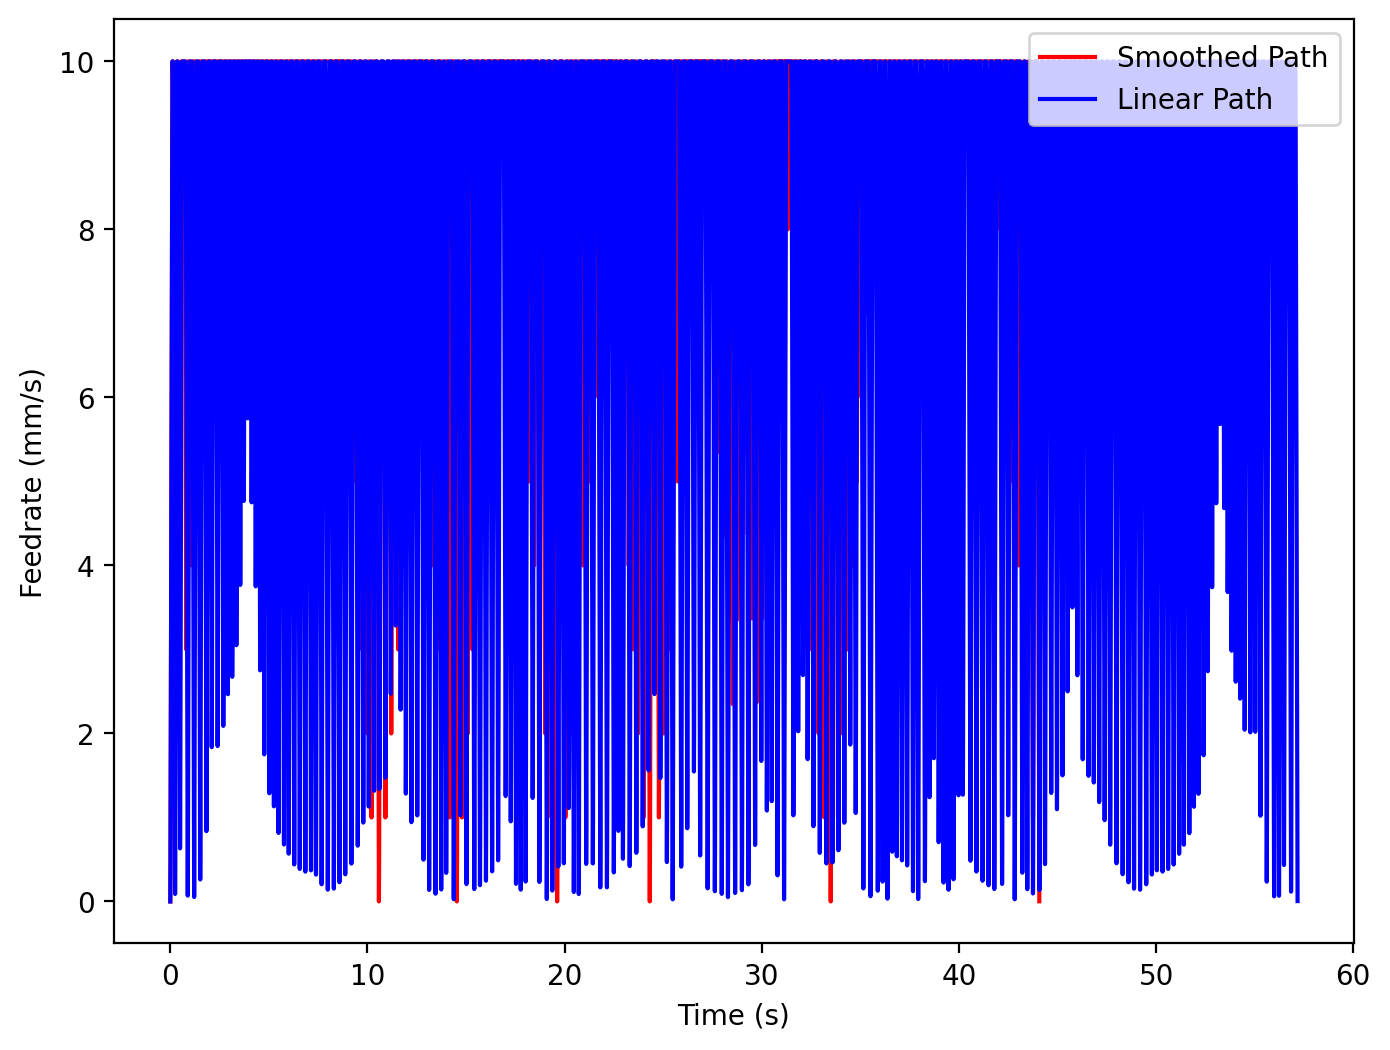

In [9]:
T_smooth, V_smooth = smooth_profile_data["T"], smooth_profile_data["V"]
T_linear, V_linear = linear_profile_data["T"], linear_profile_data["V"]
plt.figure(figsize=(8, 6))
plt.plot(T_smooth, V_smooth, "r-", label="Smoothed Path")
plt.plot(T_linear, V_linear, "b-", label="Linear Path")
plt.xlabel("Time (s)")
plt.ylabel("Feedrate (mm/s)")
plt.legend(loc="upper right")
plt.show()

## Step 4: 插补

插补周期为 `Ts`，根据 Step3 计算该周期内的位移大小，然后以此为弧长，找到到轨迹曲线上对应的位置作为插补点

In [10]:
linear_interpolator = Interpolator(linear_path, linear_scheduler, Ts)
linear_interpolated_points = linear_interpolator.interpolate()

smooth_interpolator = Interpolator(smooth_path, smooth_scheduler, Ts)
smooth_interpolated_points = smooth_interpolator.interpolate()

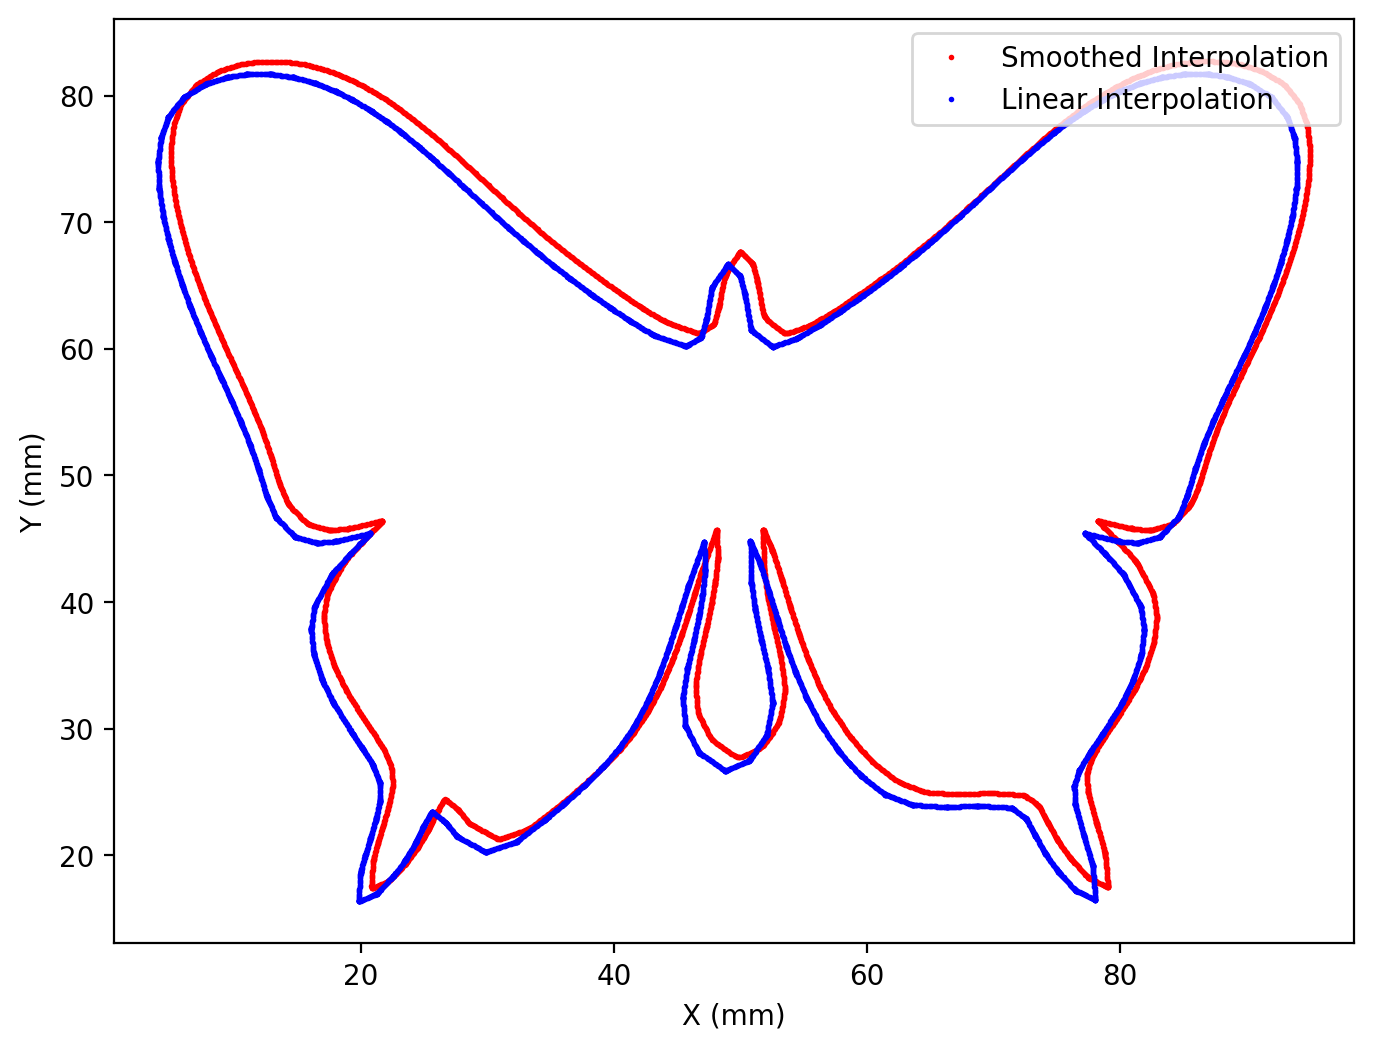

In [11]:
plt.figure(figsize=(8, 6))
sampling_ratio = 20
offset = 1
sampled_smooth_pts = smooth_interpolated_points[::sampling_ratio]
sampled_linear_pts = linear_interpolated_points[::sampling_ratio]
plt.plot(sampled_smooth_pts[:, 0], sampled_smooth_pts[:, 1], "r.", markersize=2, label="Smoothed Interpolation")
plt.plot(
    sampled_linear_pts[:, 0] - offset,
    sampled_linear_pts[:, 1] - offset,
    "b.",
    markersize=2,
    label="Linear Interpolation",
)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.legend(loc="upper right")
plt.axis("equal")
plt.show()